# Ridge Regression on Contextagnostic and DecadeAware system

In [2]:
library(tidyverse)
library(caret)
library(glmnet)
library(dplyr)
#library(psych) 
set.seed(1991)

In [7]:
CompoundAgnostic_DecadeAware<-read.csv('CompoundAgnostic_DecadeAware.csv',sep = '\t')

In [8]:
Y <- CompoundAgnostic_DecadeAware %>% select(compound_mean) %>% scale(center = TRUE, scale = FALSE) %>% as.double()
X <- CompoundAgnostic_DecadeAware %>% select(-c(1:8)) %>% as.matrix()

We use Ridge Regression to find a linear relationship between the features (PPMI, Local Mutual Information, Log Likelihood and the three similarity features) and compound_mean from the Reddy dataset for the 80 compounds.

In [9]:
lambda <- 10^seq(-3, 3, length = 100)
seeds <- vector(mode = "list", length = 11)

In [41]:
ridge <- train(
  compound_mean ~. -modifier -head -modifier_mean -modifier_std -head_mean -head_std -compound_std, 
    data = CompoundAgnostic_DecadeAware, method = "glmnet",
  trControl = trainControl("cv", number = 10,search="grid"),
  tuneGrid = expand.grid(alpha = 0, lambda = lambda)
  )

elastic <- train(
  compound_mean ~. -modifier -head -modifier_mean -modifier_std -head_mean -head_std -compound_std,
    data = CompoundAgnostic_DecadeAware, method = "glmnet",
  trControl = trainControl("cv", number = 10,search="grid"),
  tuneLength = 10
  )

lasso <- train(
  compound_mean ~. -modifier -head -modifier_mean -modifier_std -head_mean -head_std -compound_std,
    data = CompoundAgnostic_DecadeAware, method = "glmnet",
  trControl = trainControl("cv", number = 10,search="grid"),
  tuneGrid = expand.grid(alpha = 1, lambda = lambda)
  )

elastic2 <- train(
  compound_mean ~modifier_mean+modifier_std+head_mean+head_std,
    data = CompoundAgnostic_DecadeAware, method = "glmnet",
  trControl = trainControl("cv", number = 10,search="grid"),
  tuneLength = 10
  )
# Model coefficients
#coef(ridge$finalModel, ridge$bestTune$lambda)
# Make predictions
#predictions <- ridge %>% predict(test.data)
# Model prediction performance
#data.frame(
#  RMSE = RMSE(predictions, test.data$medv),
#  Rsquare = R2(predictions, test.data$medv)
#)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."

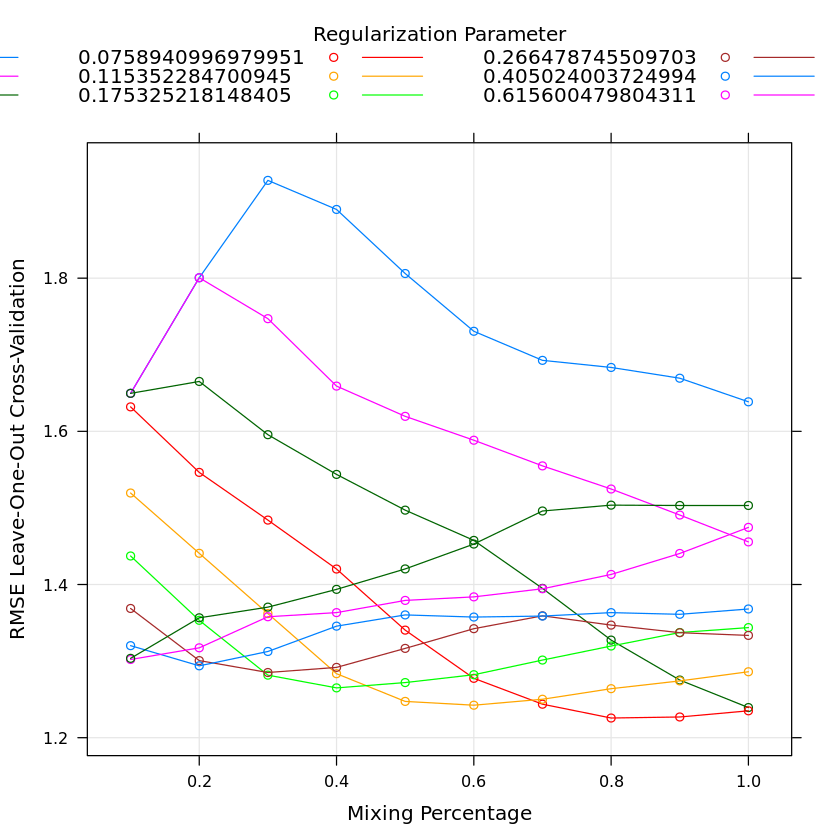

In [28]:
plot(elastic)

In [42]:
models <- list(ridge = ridge, lasso = lasso, elastic = elastic,elastic2 = elastic2)
resamples(models) %>% summary( metric = "RMSE")


Call:
summary.resamples(object = ., metric = "RMSE")

Models: ridge, lasso, elastic, elastic2 
Number of resamples: 10 

RMSE 
              Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
ridge    1.0714991 1.2084139 1.2982002 1.3082044 1.4338844 1.5298844    0
lasso    0.7696689 1.0845679 1.3335447 1.2972536 1.4766426 1.8208893    0
elastic  0.8649667 0.9983885 1.1585451 1.2413593 1.2831903 1.9974178    0
elastic2 0.2296212 0.2654678 0.3382087 0.3278846 0.3733105 0.4162047    0


In [43]:
getTrainPerf(elastic)

TrainRMSE,TrainRsquared,TrainMAE,method
1.241359,0.4329344,1.053433,glmnet


In [44]:
getTrainPerf(elastic2)

TrainRMSE,TrainRsquared,TrainMAE,method
0.3278846,0.9590771,0.2640305,glmnet


In [15]:
dev.new(width = 550, height = 900, unit = "px")

Variable Importance is used to look at the importance of a feature in predicting compound_mean. We show the top 20 features out of the possible 126 (21 decades * 6 features).

When we look at the features irrespective of the decade,

log ratio is the most important and occupies 11/20 positions with local mutual information in the other 9. 

We do not see any of the similarity features being as important as the information theory based features. 

(This is good because previous studies only looked at similarity and frequencies, but never information theory features)

Given below is the distribution of the variables that were deemed important based on the decade

1800 : 1

1830 : 2

1840 : 2

1850 : 2

1860 : 2

1870 : 2

1880 : 2

1890 : 2

1900 : 2

1910 : 2

1920 : 1

( We need to figure out how and if the decade information makes any sense)

When we compare this model with the non temporal model, we get better R squared values, so we can say that temporal information is helping us predict the compositionality score.

In [47]:
varImp(elastic)

glmnet variable importance

  only 20 most important variables shown (out of 126)

                            Overall
X2000_log_ratio           100.00000
X1860_sim_with_modifier    42.09986
X2000_ppmi                 22.41436
X1810_ppmi                 21.96914
X1990_sim_with_head        21.41637
X1950_sim_with_modifier    17.27319
X1920_ppmi                 16.64655
X1850_ppmi                 14.71932
X1840_ppmi                 10.09485
X1980_sim_with_modifier     9.24624
X1970_sim_with_head         6.01021
X1880_sim_with_head         5.78319
X2000_sim_with_head         4.77877
X1990_ppmi                  3.40402
X1880_sim_bw_constituents   1.32924
X1860_sim_with_head         0.35455
X1800_ppmi                  0.00701
X1810_sim_with_head         0.00000
X1960_sim_bw_constituents   0.00000
X1940_ppmi                  0.00000

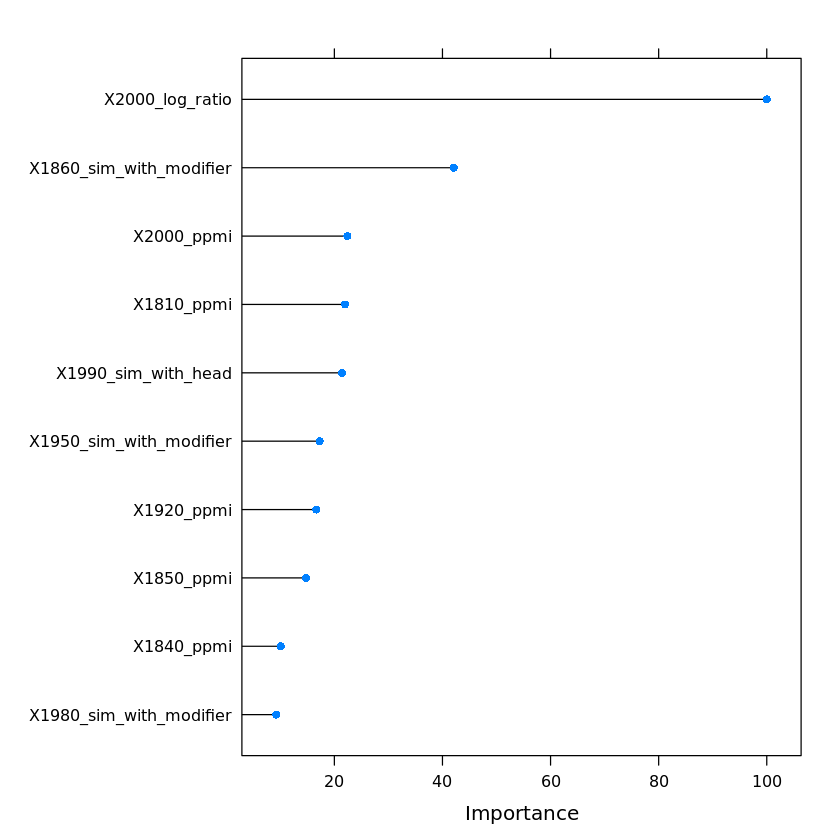

In [48]:
plot(varImp(elastic),top=10)